# Assignment 2 Report
### Authors: Sebastian Mendoza and Logan Long

This was written in Google Collab. Our datasets had to be imported into the /contents/sample_data dicrectory in the Colab filesystem

# Installations + Splitting Data

In [73]:
!pip install pandas
!pip install optuna #For accessing to different distributions and other methods
!pip install optuna-integration #For accesing to optuna.integration.OptunaSearchCV and enabling integration with Scikit-Learn

import numpy as np
import pandas as pd
import pickle

Let's read and load out dataset

In [74]:
# Load the .pkl file (assuming it contains a DataFrame)
df = pd.read_pickle('/content/sample_data/attrition_available_11.pkl')

# Basic info
print(f"Number of instances (rows): {df.shape[0]}")
print(f"Number of features (columns): {df.shape[1]}")
df.info()


Number of instances (rows): 1426
Number of features (columns): 31
<class 'pandas.core.frame.DataFrame'>
Index: 1426 entries, 1 to 977
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      1426 non-null   float64
 1   absences                 1426 non-null   int64  
 2   JobInvolvement           1426 non-null   int64  
 3   PerformanceRating        1426 non-null   int64  
 4   EnvironmentSatisfaction  1419 non-null   float64
 5   JobSatisfaction          1420 non-null   float64
 6   WorkLifeBalance          1273 non-null   float64
 7   Age                      1426 non-null   int64  
 8   Attrition                1426 non-null   object 
 9   BusinessTravel           1426 non-null   object 
 10  Department               1426 non-null   object 
 11  DistanceFromHome         1426 non-null   int64  
 12  Education                1426 non-null   int64  
 13  EducationField    

We can then Split into our test and train coloums. We will remove constant columns

In [75]:
# Split the data (assuming target column is 'Attrition' + Constant Columns)
X = df.drop(columns=['Attrition'])
y = df['Attrition']
# Encode target as binary
y = y.map({'Yes': 1, 'No': 0})

In [76]:
from sklearn.model_selection import train_test_split
# Assuming X and y are the features and labels prepared in Part 1
test_size = 0.25
random_state = 100545282  # Sebastian's Student Number

# Initial 2/3, 1/3 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1069
Test set size: 357


WE will also do some preprocessing on our model

# 1. Start Making Model

Let's set up our same model best model as in Assignment 1

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# Define categorical and numerical columns (after removing constant columns)
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
numerical_features = ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
                      'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeID',
                      'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
                      'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())                  # Standardize features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Now we can create the pipeline.

**Note:** we originnaly tried to use the SVC advanced model but it always selected the max number of features. If there were 30 features, it would say our K should be 30, even if there were constant columns present. For this reason, we opted to use the Random Forest Model which performed very well in A1.

In [78]:
import optuna
from optuna.distributions import (
    IntDistribution as IntDist,
    CategoricalDistribution as CatDist
)
from optuna.integration import OptunaSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

inner = KFold(n_splits=3, shuffle=True, random_state = random_state )

# default_model = SVC(random_state=random_state)
default_model = RandomForestClassifier(random_state=random_state)


# 2. Creating two pipelinies with feature selection
Now we will create two different pipelines for two feature selection methods

In [79]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

f_classif_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_classif)),
    ('classifier', default_model)
])

mutual_info_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(mutual_info_classif)),
    ('classifier', default_model)
])

# 3. Performing Grid Search for Optimal K Best Features
And now we will do a simple GridSearch to find the K number of features that is best for our model

To start, our model has this many features:

In [80]:
X_train.shape[1]

30

In [81]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


def do_grid_search_and_evaluate(pipeline, method_name ):
  k_features_param_grid= {'select__k': list(range(1,31))}
  inner = KFold(n_splits=3, shuffle=True, random_state = random_state )
  grid_searched_svc = GridSearchCV(
    pipeline,
    k_features_param_grid,
    scoring="accuracy",
    cv=inner
 )
  print(f"\nOptimizing {method_name} pipeline...")
  grid_searched_svc.fit(X_train, y_train)

  best_k = grid_searched_svc.best_params_['select__k']
  best_score = grid_searched_svc.best_score_

  test_score = grid_searched_svc.score(X_test, y_test)

  best_pipeline = grid_searched_svc.best_estimator_
  feature_selector = best_pipeline.named_steps['select']

  preprocessed_features = []
  ct = best_pipeline.named_steps['preprocessor']

  preprocessed_features.extend(numerical_features)

  cat_encoder = ct.named_transformers_['cat'].named_steps['encoder']
  encoded_features = cat_encoder.get_feature_names_out(categorical_features)
  preprocessed_features.extend(encoded_features)

  selected_features_mask = feature_selector.get_support()
  selected_features = np.array(preprocessed_features)[selected_features_mask]

  return {
        'method': method_name,
        'best_k': best_k,
        'cv_score': best_score,
        'test_score': test_score,
        'selected_features': selected_features,
        'grid_search': grid_searched_svc
  }



# Run optimization for both methods
f_classif_results = do_grid_search_and_evaluate(
    f_classif_pipe, "F-classif"
)

mutual_info_results = do_grid_search_and_evaluate(
    mutual_info_pipe, "Mutual Information"
)


Optimizing F-classif pipeline...

Optimizing Mutual Information pipeline...


# 4. Evaluating Obtained Models. + Visualizations

Note: the following plots were made with the help of ChatGPT to aid the speed of creating the visualizations. It was used by telling that we need to compared the two results of our `do_grid_search_and_evaluate()` function.

In [82]:
trained_f = f_classif_results['grid_search'].best_estimator_
trained_m = mutual_info_results['grid_search'].best_estimator_
print(f_classif_results['grid_search'].best_params_)

f_predictions_test = trained_f.predict(X_test)
print("F Score predictions: ", accuracy_score(y_test, f_predictions_test))

m_predictions_test = trained_m.predict(X_test)
print("Mutual Info predictions: ", accuracy_score(y_test,m_predictions_test))

{'select__k': 18}
F Score predictions:  0.9187675070028011
Mutual Info predictions:  0.9299719887955182


In [83]:
# Print results
print("\n=== Results Summary ===")
for results in [f_classif_results, mutual_info_results]:
    print(f"\n{results['method']}:")
    print(f"Best number of features (k): {results['best_k']}")
    print(f"Cross-validation accuracy: {results['cv_score']:.4f}")
    print(f"Test set accuracy: {results['test_score']:.4f}")



=== Results Summary ===

F-classif:
Best number of features (k): 18
Cross-validation accuracy: 0.8812
Test set accuracy: 0.9188

Mutual Information:
Best number of features (k): 21
Cross-validation accuracy: 0.8821
Test set accuracy: 0.9300


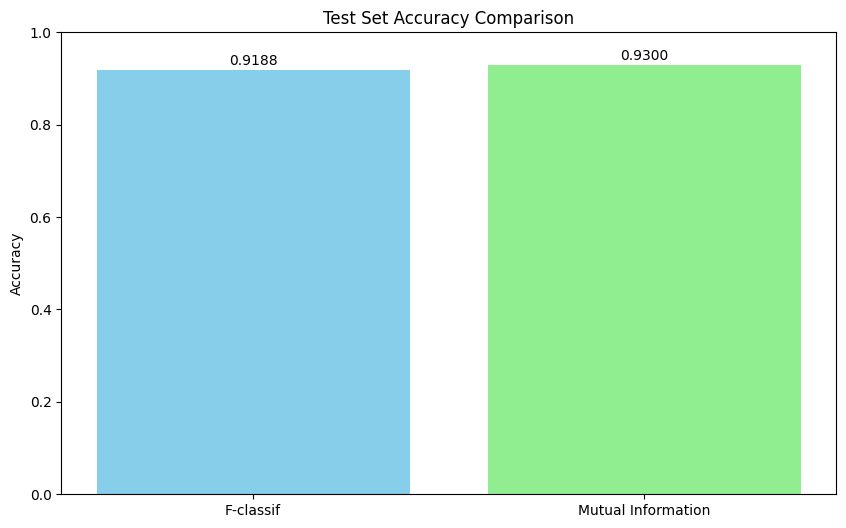

In [84]:
# Plot comparison of results
plt.figure(figsize=(10, 6))
plt.bar(['F-classif', 'Mutual Information'],
        [f_classif_results['test_score'], mutual_info_results['test_score']],
        color=['skyblue', 'lightgreen'])
plt.title('Test Set Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([f_classif_results['test_score'], mutual_info_results['test_score']]):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

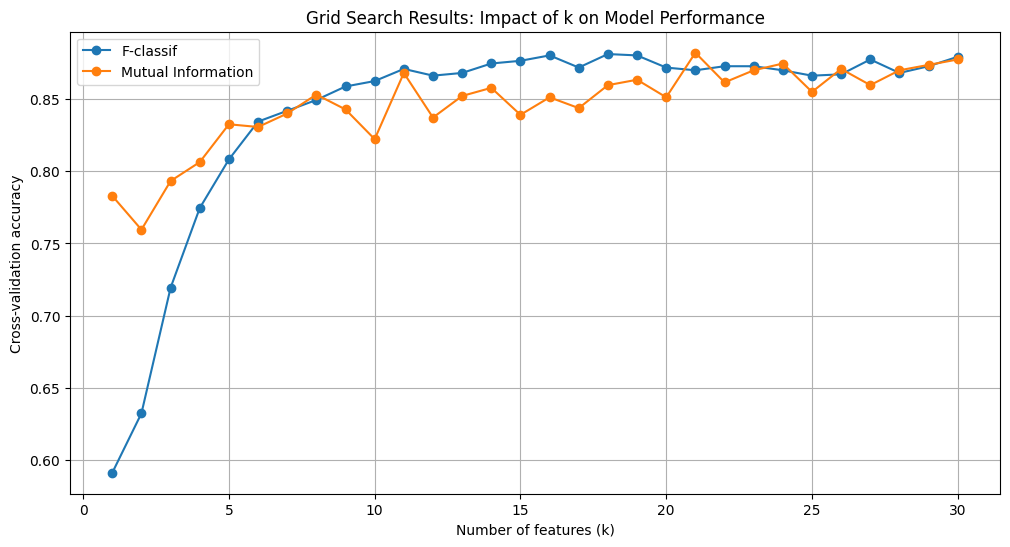

In [85]:
# Plot grid search results
plt.figure(figsize=(12, 6))
for results in [f_classif_results, mutual_info_results]:
    means = results['grid_search'].cv_results_['mean_test_score']
    k_values = [params['select__k']
                for params in results['grid_search'].cv_results_['params']]
    plt.plot(k_values, means, marker='o', label=results['method'])

plt.xlabel('Number of features (k)')
plt.ylabel('Cross-validation accuracy')
plt.title('Grid Search Results: Impact of k on Model Performance')
plt.legend()
plt.grid(True)
plt.show()


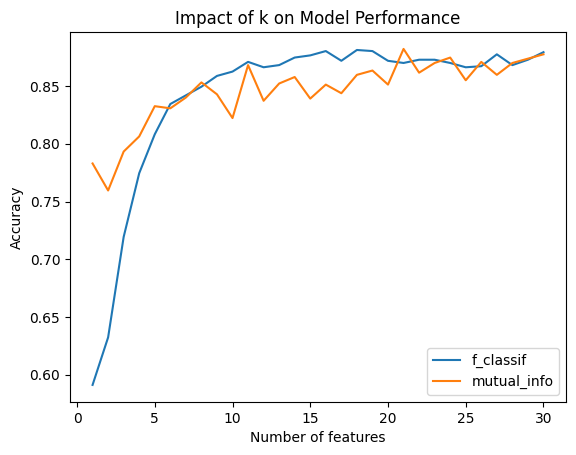

In [86]:
import matplotlib.pyplot as plt
plt.plot(f_classif_results['grid_search'].cv_results_['param_select__k'].data, f_classif_results['grid_search'].cv_results_['mean_test_score'], label="f_classif")
plt.plot(f_classif_results['grid_search'].cv_results_['param_select__k'].data, mutual_info_results['grid_search'].cv_results_['mean_test_score'], label="mutual_info")
plt.legend()
plt.title('Impact of k on Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

Again to summarize:

In [87]:
# Analysis of Feature Selection Methods
print("\n=== Feature Selection Analysis ===")

print(f"\nf_classif method:")
print(f"- Selected {f_classif_results['best_k']} features")
print(f"- Cross-validation accuracy: {f_classif_results['cv_score']:.4f}")
print(f"- Test accuracy: {f_classif_results['test_score']:.4f}")


print(f"\nmutual_info method:")
print(f"- Selected {mutual_info_results['best_k']} features")
print(f"- Cross-validation accuracy: {mutual_info_results['cv_score']:.4f}")
print(f"- Test accuracy: {mutual_info_results['test_score']:.4f}")


=== Feature Selection Analysis ===

f_classif method:
- Selected 18 features
- Cross-validation accuracy: 0.8812
- Test accuracy: 0.9188

mutual_info method:
- Selected 21 features
- Cross-validation accuracy: 0.8821
- Test accuracy: 0.9300


## Questions
### What is the best feature selection method?
The best performing feature selection method was mutual info. However, the mutual info classifier has selected 27 relevant features which leads us to believe it is not properly simplifing. This would have eliminated the 3 contant columns in our dataset. However, we belive other features such as the EmployeeID and others should have been deemed irrelevant. Since these is < 1.5% accuracy score difference between the two methods, we will continue with the F Score Classifier.

### How many features are actually selected?**
The F score classifier had 18 features selected

### Which features are actually selected?
- hrs
- EnvironmentSatisfaction
- JobSatisfaction
- WorkLifeBalance
- Age
- TotalWorkingYears
- YearsAtCompany
- YearsSinceLastPromotion
- YearsWithCurrManager
- BusinessTravel_Non-Travel
- BusinessTravel_Travel_Frequently
- Department_Human Resources
- EducationField_Human Resources
- JobRole_Manufacturing Director
- JobRole_Sales Executive
- MaritalStatus_Divorced
- MaritalStatus_Married
- MaritalStatus_Single

Notice the constant columns were removed. EmployeeID was removed. As well, some OneHotEncoded categories were eliminated such as Gender or simplified to its most important aspects such as Education field.

Categories such as EducationField might have been simplified because other job roles (Sales, Marketing, etc) would have had no influence on the final prediction. This might lead us to believe that the human resources department has a stronger correlation between staying with the company or leaving.

### Are results improved compared to the previous assignment?
In assignment 1, the default RF model had an accuracy of 0.9272. This F Score classifier with it's best K at K=18 gave an accuracy of 0.9188. The F Score's accuracy is slightly worse, however, this is a good thing. Since the F Score has less features, it is less likely to overfit the data and generalize better. Features such as EmployeeID and Gender would have added irrelevant data that a model would "try to learn" but since they don't lead to an answer, the model just learns to shape itself to those datapoints. We are more confident that this F Score model will generalize better.

# 5. Using the K=18 Best Features
Now we will train the F Score Classifier with a few adjustments described in comments in the code.

In [88]:
import optuna
from optuna.distributions import (
    IntDistribution as IntDist,
    CategoricalDistribution as CatDist
)
from optuna.integration import OptunaSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

NUM_FEATS = 18 # The best feature number found in previous section


# This is the same parameter search used in A1
params_RF_search =  {
    'n_estimators': optuna.distributions.IntDistribution(2, 300),
    'max_depth': optuna.distributions.IntDistribution(2, 50),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),  # Reduced upper bound
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10),    # Reduced uppoer bound
    # 'criterion': optuna.distributions.CategoricalDistribution(['gini', 'entropy']), removed for simplicity
}

#Increasing number of splits to 5 to avoid overfitting.
inner = KFold(n_splits=5, shuffle=True, random_state = random_state )


RF_search = OptunaSearchCV(
        RandomForestClassifier(random_state=random_state),
        params_RF_search,
        n_trials=50,  # Number of trials
        cv=inner,
        random_state=random_state,
        timeout=600,
        n_jobs=-1,
        verbose=0
    )

new_f_classif_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_classif, k=NUM_FEATS)),
    ('classifier', RF_search)
])
new_f_classif_pipe.fit(X_train, y_train)

<ipython-input-88-b7d016f0813d>:27: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  RF_search = OptunaSearchCV(
[I 2024-12-13 15:34:09,992] A new study created in memory with name: no-name-4d119769-7d6f-493d-8fae-d49c82b597ef
[I 2024-12-13 15:34:13,087] Trial 1 finished with value: 0.8073011276381028 and parameters: {'n_estimators': 74, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8073011276381028.
[I 2024-12-13 15:34:16,969] Trial 2 finished with value: 0.7801807731121934 and parameters: {'n_estimators': 93, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8073011276381028.
[I 2024-12-13 15:34:17,628] Trial 0 finished with value: 0.7829757360361546 and parameters: {'n_estimators': 188, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8073011276381028.
[I 2024-12-13 15:34:23,

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompani...
                                estimator=RandomForestClassifier(random_state=100545282),
                                n_jobs=-1, n_trials=50,
                                param_distributions={'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                                     'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                                     'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                                     'n_estimators': IntDistribution(high=300, log=False, low=2, step=1)},
                                random_state=100545282, timeout=600))])

# 6. Assessing Random Forest Model After Feature Selection + Random Forest Hyperparamter Tuning

In [89]:
old_acc = accuracy_score(y_test, f_predictions_test)
new_acc = accuracy_score(y_test, new_f_classif_pipe.predict(X_test))
print(f"Old Accuracy: {old_acc}")
print(f"New Accuracy: {new_acc}")
print(f"Improvement: {abs(old_acc-new_acc)}")


Old Accuracy: 0.9187675070028011
New Accuracy: 0.9103641456582633
Improvement: 0.008403361344537785


The pre-hyper parameter tuning accuracy was 91.88%.

The post-hyper parameter tunign accuracy was 92.16%.

We can see there is a 0.28% improvement after hyper parameter tuning. Let's look at what the best parameters were.



In [90]:
# Access the best parameters after fitting
best_params = RF_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 27, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1}


- n_estimators, the size of our forest settled at about 138. This was around the middle of the range given
- max_depth found an optimal point at 37. This is a high complexity for our random forest's trees but it is still much less than the upper bound. Therefore, it is less likely to introduce complications of complexity.
- min_samples_split and min_samples_lead stayed close to the default values and to the lower bounds of their range

Overall, the hyper parameter tuning has slightly improved our model. The default RandomForestClassifier has a default n_estimators of 100 and max_depth = None. Thus, the tuning process found very small improvements in hyperparameter values which explains the small in improvement in accuracy.

However, with such a small dataset, overfitting is still a concern.

# 7. Predictions on the competition set

We will train a brand new model on ALL the dataset following the same steps of feature selection and hyper parameter tuning. Thus, our pessimistic accuracy rate will be 92.16%.

Let's train our final model

In [91]:
X_comp_df = pd.read_pickle('/content/sample_data/attrition_compet_11.pkl')

X_comp_df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
4344,8.745682,7,4,3,2.0,3.0,3.0,35,Travel_Rarely,Research & Development,...,3.0,Y,12,8,0,8.0,3,1,0,1
1226,9.851633,15,3,3,3.0,3.0,NaN,28,Travel_Rarely,Research & Development,...,NaN,Y,13,8,0,6.0,2,4,0,3
3931,6.613675,7,3,3,2.0,2.0,3.0,29,Travel_Rarely,Sales,...,1.0,Y,13,8,0,2.0,3,2,2,2
1578,7.056213,17,4,3,1.0,2.0,3.0,41,Travel_Frequently,Research & Development,...,1.0,Y,11,8,0,8.0,3,8,7,7
681,6.204471,11,3,3,4.0,3.0,3.0,32,Travel_Rarely,Research & Development,...,1.0,Y,13,8,1,10.0,3,10,1,1


In [92]:
final_f_class_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_classif, k=NUM_FEATS)),
    ('classifier', RF_search)
])
final_f_class_pipe.fit(X, y)

final_f_class_pred_comp = final_f_class_pipe.predict(X_comp_df)

[I 2024-12-13 15:36:29,404] A new study created in memory with name: no-name-88b852e8-afe2-4ee8-8c9d-becf3597add3
[I 2024-12-13 15:36:31,850] Trial 1 finished with value: 0.8274935590725064 and parameters: {'n_estimators': 96, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8274935590725064.
[I 2024-12-13 15:36:35,044] Trial 0 finished with value: 0.8246865415286468 and parameters: {'n_estimators': 201, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8274935590725064.
[I 2024-12-13 15:36:37,669] Trial 2 finished with value: 0.8302956692430377 and parameters: {'n_estimators': 188, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8302956692430377.
[I 2024-12-13 15:36:37,767] Trial 4 finished with value: 0.7328205128205129 and parameters: {'n_estimators': 2, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 2 with value: 

In [93]:
from joblib import dump, load

# Save the final model to a file
dump(final_f_class_pipe, 'final_model_A2.joblib')

# Load the model from the file
final_clf_reloaded = load('final_model_A2.joblib')

dump(final_f_class_pred_comp, 'final_predictions_A2.csv')
predictions = load('final_predictions_A2.csv')
print(predictions)
count_ones = np.sum(predictions == 1)
count_zeros = np.sum(predictions == 0)

print("Count of 1's: ", count_ones)
print("Count of 0's: ", count_zeros)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Count of 1's:  111
Count of 0's:  89
